In [7]:
## IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [6]:
ds_summary = xr.open_dataset('../data/outputs/correlation_sst_desembarques.nc')
ds_summary_apr_jul_smoothed = xr.open_dataset('../data/outputs/correlation_sst_desembarques_5day_rolling_apr_jul.nc')
ds_summary_nov_jan_smoothed = xr.open_dataset('../data/outputs/correlation_sst_desembarques_5day_rolling_nov_jan.nc')

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'pydap']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [17]:
# Open geometry datasets
file_path_puertos = '../data/puertos/processed/ports_with_normal_angles_corrected.csv'

df_ports = pd.read_csv(file_path_puertos, index_col=False)

port_groups_dict = {'Group 1': ['CALETA_TORTUGA_(PAITA)', 'CALETA_PARACHIQUE'],
 'Group 2': ['PUERTO_CHIMBOTE', 'PUERTO_SAMANCO'],
 'Group 3': ['PUERTO_HUARMEY',
  'PUERTO_SUPE',
  'DPA_HUACHO_-_FONDEPES',
  'PUERTO_CHANCAY',
  'DPA_CALLAO'],
 'Group 4': ['PUERTO_TAMBO_DE_MORA',
  'TERMINAL_MARINO_PISCO-CAMISEA_(PLUSPETRO)'],
# 'Group 5': ['CALETA_ATICO', 'CALETA_PLANCHADA'],
# 'Group 6': ['DPA_ILO']
}

port_list_original_name = [ 
    'CALETA_TORTUGA_(PAITA)', 'CALETA_PARACHIQUE', 'PUERTO_CHIMBOTE',  
    'PUERTO_SAMANCO',  'PUERTO_HUARMEY', 'PUERTO_SUPE', 
    'DPA_HUACHO_-_FONDEPES','PUERTO_CHANCAY', 'DPA_CALLAO', 
    'PUERTO_TAMBO_DE_MORA', 'TERMINAL_MARINO_PISCO-CAMISEA_(PLUSPETRO)',
    'CALETA_ATICO', 'CALETA_PLANCHADA', 'DPA_ILO'
]

port_list_full_name = [
    'Caleta  tortuga (Paita)',
    'Caleta Parachique',
    'Puerto Chimbote',
    'Puerto Samanco',
    'Puerto Huarmey',
    'Puerto Supe',
    'DPA Huacho - FONDEPES',
    'Puerto Chancay',
    'DPA Callao',
    'Puerto Tambo de Mora',
    'Terminal Marino Pisco-Camisea (Pluspetro)',
    'Caleta Atico',
    'Caleta Planchada',
    'DPA Ilo'
]
port_groups_full = {}
for group, orig_ports in port_groups_dict.items():
    mapped_ports = []
    for port in orig_ports:
        if port in port_list_original_name:
            idx = port_list_original_name.index(port)
            mapped_ports.append(port_list_full_name[idx])
    port_groups_full[group] = mapped_ports



In [28]:
group_colors = {
    'Group 1': 'red',
    'Group 2': 'green',
    'Group 3': 'blue',
    'Group 4': 'orange',
#    'Group 5': 'purple',
#    'Group 6': 'cyan'
}


lon = ds_summary['lon']
lat = ds_summary['lat']
lon_min, lon_max = np.round(lon.min().values * 2) / 2, np.round(lon.max().values * 2) / 2
lat_min, lat_max = np.round(lat.min().values * 2) / 2, np.round(lat.max().values * 2) / 2
lon_ticks = np.linspace(lon_min, lon_max, num=min(5, int((lon_max - lon_min) / 0.5) + 1))
lat_ticks = np.linspace(lat_min, lat_max, num=min(5, int((lat_max - lat_min) / 0.5) + 1))



<Figure size 1600x1000 with 0 Axes>

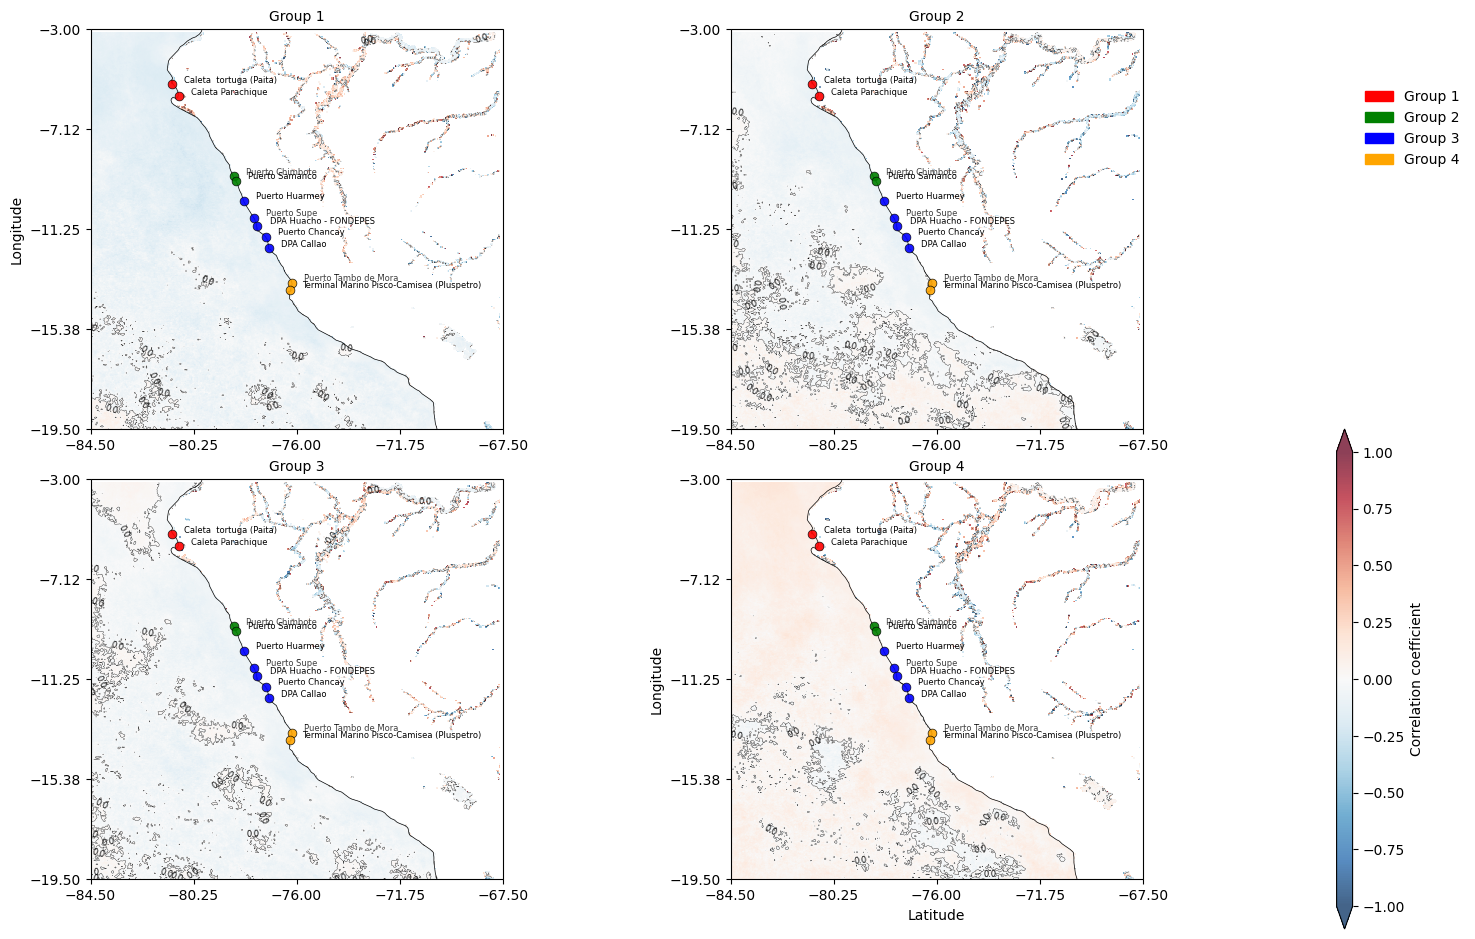

In [31]:

fig = plt.figure(figsize=(16,10))

axes_loc = [
    [0.10, 0.55, 0.4, 0.4],  # Arriba izquierda
    [0.50, 0.55, 0.4, 0.4],  # Arriba derecha
    [0.10, 0.10, 0.4, 0.4],   # Abajo izquierda
    [0.50, 0.10, 0.4, 0.4],  # Abajo derecha
]

axes = []

vars = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
for i, v in enumerate(vars):
    ax = axes_loc[i]
    
    data = ds_summary[v]

    ax = plt.axes(ax, projection=ccrs.PlateCarree())
    axes.append(ax)

    im = ax.pcolormesh(lon, lat, data, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha=0.75)
    levels = np.arange(np.floor(-1), np.ceil(1) + 0.5, 0.5)

    contours = ax.contour(lon, lat, data, levels=levels, colors='k', linewidths=0.25, transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{v}", fontsize=10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    

    if i%3==0:
        ax.set_ylabel('Longitude')
    if i>=3:
        ax.set_xlabel('Latitude')


ax_cbar = plt.axes([0.95, 0.05, 0.01, 0.5])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Correlation coefficient")

legend_handles = [mpatches.Patch(color=group_colors[group], label=group) for group in group_colors]
fig.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.96, 0.8), frameon=False)

fig.savefig('../docs/figs/MODIS/corr_sst_produccion.png', dpi=300, bbox_inches='tight')
fig.savefig('../docs/figs/MODIS/corr_sst_produccion.pdf', bbox_inches='tight')
#plt.close()
    

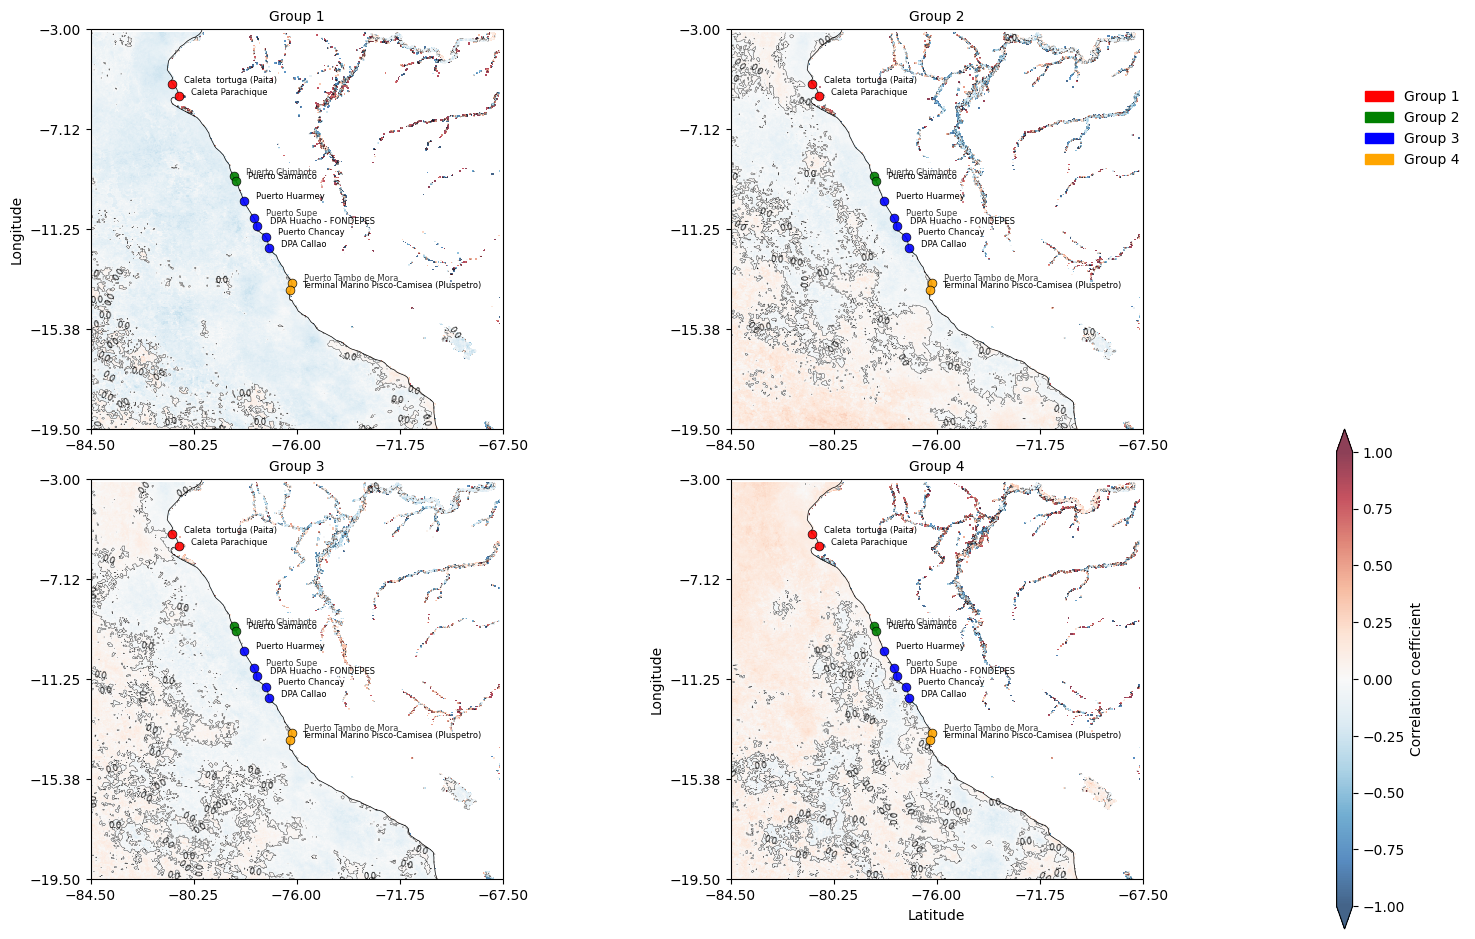

In [34]:

fig = plt.figure(figsize=(16,10))

axes_loc = [
    [0.10, 0.55, 0.4, 0.4],  # Arriba izquierda
    [0.50, 0.55, 0.4, 0.4],  # Arriba derecha
    [0.10, 0.10, 0.4, 0.4],   # Abajo izquierda
    [0.50, 0.10, 0.4, 0.4],  # Abajo derecha
]

for i, v in enumerate(vars):
    ax = axes_loc[i]
    
    data = ds_summary_nov_jan_smoothed[v]

    ax = plt.axes(ax, projection=ccrs.PlateCarree())
    axes.append(ax)

    im = ax.pcolormesh(lon, lat, data*2 cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha=0.75)
    levels = np.arange(np.floor(-1), np.ceil(1) + 0.5, 0.5)

    contours = ax.contour(lon, lat, data, levels=levels, colors='k', linewidths=0.25, transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{v}", fontsize=10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    

    if i%3==0:
        ax.set_ylabel('Longitude')
    if i>=3:
        ax.set_xlabel('Latitude')


ax_cbar = plt.axes([0.95, 0.05, 0.01, 0.5])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Correlation coefficient")


legend_handles = [mpatches.Patch(color=group_colors[group], label=group) for group in group_colors]
fig.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.96, 0.8), frameon=False)


fig.savefig('../docs/figs/MODIS/corr_sst_produccion_nov_jan_smoothed.png', dpi=300, bbox_inches='tight')
fig.savefig('../docs/figs/MODIS/corr_sst_produccion_nov_jan_smoothed.pdf', bbox_inches='tight')
#plt.close()


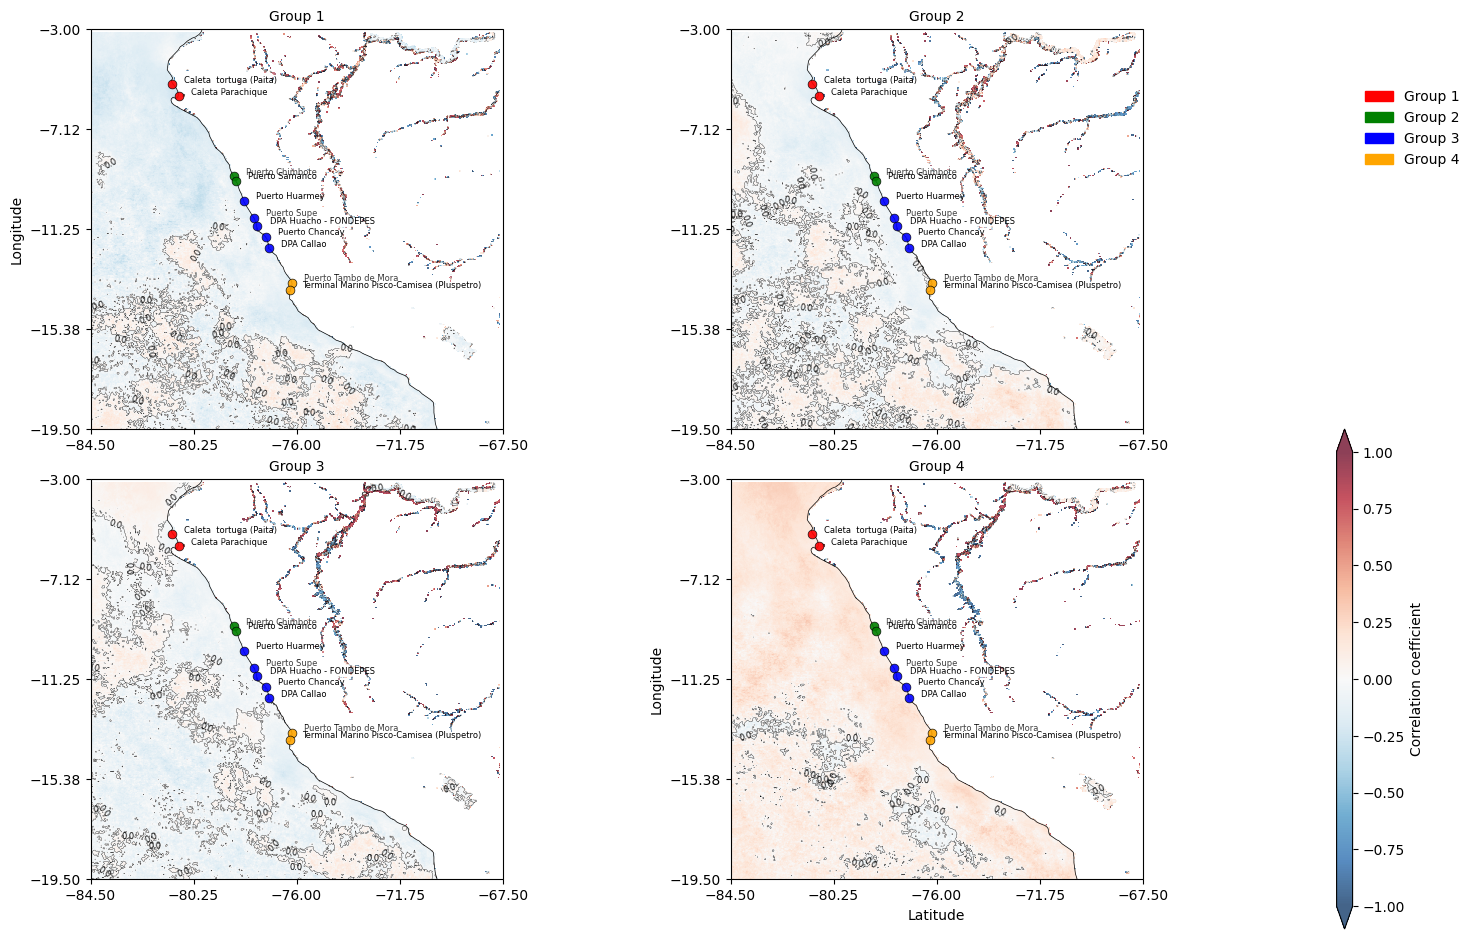

In [35]:

fig = plt.figure(figsize=(16,10))

axes_loc = [
    [0.10, 0.55, 0.4, 0.4],  # Arriba izquierda
    [0.50, 0.55, 0.4, 0.4],  # Arriba derecha
    [0.10, 0.10, 0.4, 0.4],   # Abajo izquierda
    [0.50, 0.10, 0.4, 0.4],  # Abajo derecha
]

for i, v in enumerate(vars):
    ax = axes_loc[i]
    
    data = ds_summary_apr_jul_smoothed[v]

    ax = plt.axes(ax, projection=ccrs.PlateCarree())
    axes.append(ax)

    im = ax.pcolormesh(lon, lat, data*2, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha=0.75)
    levels = np.arange(np.floor(-1), np.ceil(1) + 0.5, 0.5)

    contours = ax.contour(lon, lat, data, levels=levels, colors='k', linewidths=0.25, transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{v}", fontsize=10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    

    if i%3==0:
        ax.set_ylabel('Longitude')
    if i>=3:
        ax.set_xlabel('Latitude')


ax_cbar = plt.axes([0.95, 0.05, 0.01, 0.5])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Correlation coefficient")


legend_handles = [mpatches.Patch(color=group_colors[group], label=group) for group in group_colors]
fig.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.96, 0.8), frameon=False)


fig.savefig('../docs/figs/MODIS/corr_sst_produccion_apr_jul_smoothed.png', dpi=300, bbox_inches='tight')
fig.savefig('../docs/figs/MODIS/corr_sst_produccion_apr_jul_smoothed.pdf', bbox_inches='tight')
#plt.close()
